In [2]:
import matplotlib.pyplot as plt

import numpy as np
from skimage import io
from skimage.transform import AffineTransform
from skimage.measure import ransac
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import match_descriptors, plot_matched_features, SIFT

# Creating a feature template
This notebook demonstrates object recognition using SIFT features. We start by creating a template of a face based on features extracted from a single image. We can then attempt to match those features to similar features in other images.

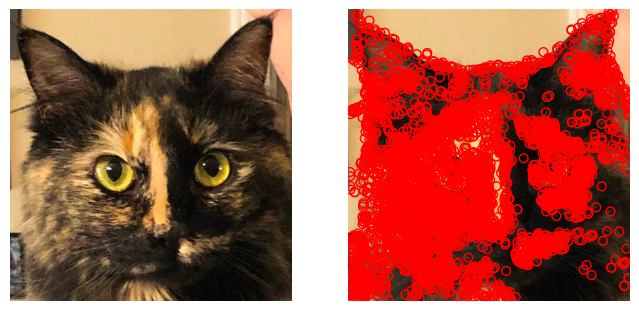

In [3]:
img1 = io.imread('img/bobbie_template.JPG')

# Extract keypoints from image using SIFT
img1_gray = rgb2gray(img1)
sift = SIFT()
sift.detect_and_extract(img1_gray)
keypoints1 = sift.keypoints
descriptors1 = sift.descriptors

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].imshow(img1)
ax[1].axis('off')
ax[1].scatter(keypoints1[:, 1], keypoints1[:, 0], facecolor='none', edgecolor='r', s=40)
plt.show()

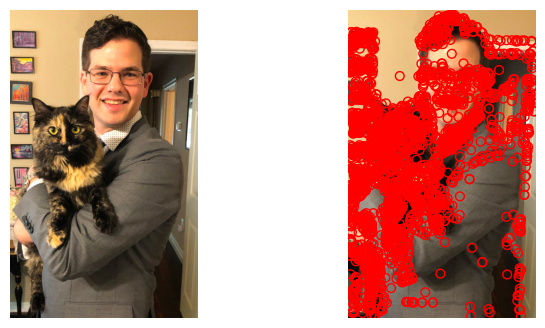

In [4]:
img2 = io.imread('img/bobbie1.JPG')

# Extract keypoints from image using SIFT
img2_gray = rgb2gray(img2)
sift.detect_and_extract(img2_gray)
keypoints2 = sift.keypoints
descriptors2 = sift.descriptors

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(img2)
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].scatter(keypoints2[:, 1], keypoints2[:, 0], facecolor='none', edgecolor='r', s=40)
plt.show()

# Matcing Descriptors
Now that we have two sets of descriptors, we can using `match_descriptors` from `skimage.feature` to find the best matches.  This algorithm implements a brute force search by comparing each descriptor in the first set to every descriptor in the second set.

As we will see, there are many matches that do not correspond to the same object. We can limit ambiguous matches by limiting the maximum ratio between the first and second closest descriptor in the second set. This ratio is known as the Lowe's ratio and is a common heuristic for filtering ambiguous matches. The ratio is calculated as follows:

$$r = \frac{d_1}{d_2}$$

where $d_1$ and $d_2$ are the distances between the first and second closest descriptors in the second set.

For example, if the first closest descriptor is 0.6 and the second closest descriptor is 0.8, then the Lowe's ratio is 0.75. If we set the Lowe's ratio to 0.8, then we will only keep matches where the first closest descriptor is less than 0.8 times the distance of the second closest descriptor. In this case, we would keep the match.

More information can be found in the [SIFT paper](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) and this [StackOverflow answer](https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work).

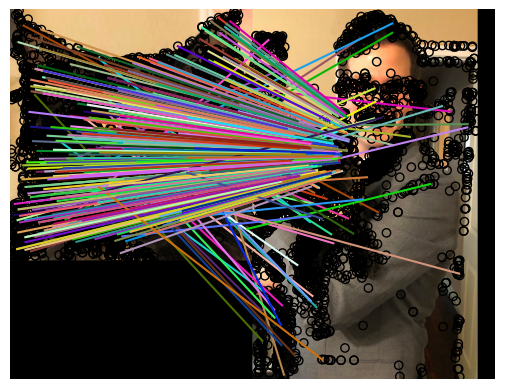

In [7]:
# Match descriptors between img1 and img2
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=0.8)

# Display matches
fig, ax = plt.subplots()
plot_matched_features(img1, img2, keypoints0=keypoints1, keypoints1=keypoints2, matches=matches12, ax=ax)
ax.axis('off')
plt.show()

After limiting the max ratio of the closest descriptors, we see that the template features are in fact being matched to what appear to be the same features in the test image.

We should not be convinced by this just yet. These are only point-wise matches that do not take into account the spatial relationship between the features. It is possible that these template features match to the test image features in a way that is not consistent with the template image.

The question becomes: how do we know that the features in the test image are in fact the same features in the template image? 

One answer to this is to use a homography to transform the template features to the test image features. If the features are in fact the same, then the transformed template features should be in the same location as the test image features.

In practice, this is accomplished using [RANdom SAmple Consensus](https://dillhoffaj.utasites.cloud/posts/random_sample_consensus/).

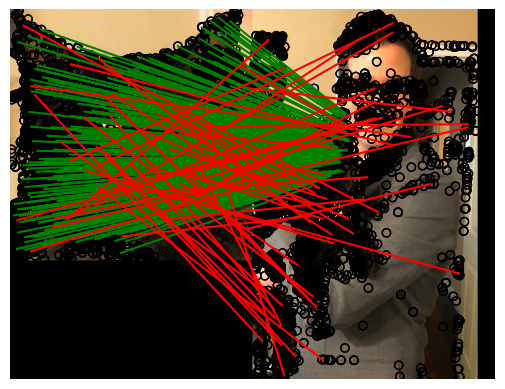

In [9]:
model12, inliers12 = ransac((keypoints1[matches12[:, 0]][:, ::-1], keypoints2[matches12[:, 1]][:, ::-1]),  # source and destination coordinates
                            AffineTransform,  # the model class
                            min_samples=3,  # minimum number of coordinates to fit the model
                            residual_threshold=2,  # maximum distance for a data point to be considered an inlier
                            max_trials=100)  # maximum number of iterations
outliers12 = inliers12 == False

# Display inlier and outlier matches
fig, ax = plt.subplots()
plot_matched_features(img1, img2, keypoints0=keypoints1, keypoints1=keypoints2, matches=matches12[inliers12], matches_color='g', ax=ax)
plot_matched_features(img1, img2, keypoints0=keypoints1, keypoints1=keypoints2, matches=matches12[outliers12], matches_color='r', ax=ax)
ax.axis('off')
plt.show()

# Match Confidence

Can we be satisfied that this is a good match? What if 90% of the features match, but the remaining 10% are incorrect? We can use the homography to calculate the error of the match. The error is the sum of the squared distances between the transformed template features and the test image features.

We can use this error to determine the confidence of the match. If the error is small, then we can be confident that the features are in fact the same. If the error is large, then we should be suspicious of the match.

In [10]:
# Get indices of matching keypoints for each of the images
kp1_idxs = matches12[inliers12, 0]
kp2_idxs = matches12[inliers12, 1]

# Get coordinates of matching keypoints for each of the images
matching_keypoints1 = keypoints1[kp1_idxs][:, ::-1] # keypoints are row, col but we want x, y
matching_keypoints2 = keypoints2[kp2_idxs][:, ::-1]
transformed_kp1 = model12(matching_keypoints1)

# Compute sum of squared distances between matched keypoints
distances = np.sum((transformed_kp1 - matching_keypoints2)**2, axis=1)
# Compute mean squared distance
mean_distance = np.mean(distances)
print('Mean squared distance: {}'.format(mean_distance))

Mean squared distance: 0.2286169852751668


# Match Confidence Part Deux

In the previous test, we used the error of the transformed keypoints as compared to the target keypoints to determine the confidence of the estimated homography. What if only a small portion of the keypoints are transformed? The error will be small, but we should be skeptical of the match.

We can also evaluate the confidence of the match by calculating the ratio of the number of inliers to the total number of matches.

Another way to evaluate the confidence of the match is to calculate the ratio of the number of inliers to the total number of keypoints in the template image.

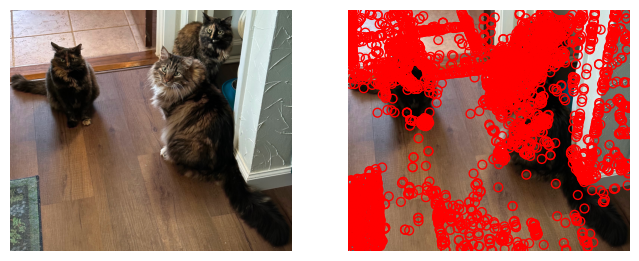

In [11]:
img3 = io.imread('img/bobbie3.JPG')

# Extract keypoints from image using SIFT
img3_gray = rgb2gray(img3)
sift.detect_and_extract(img3_gray)
keypoints3 = sift.keypoints
descriptors3 = sift.descriptors

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(img3)
ax[0].axis('off')
ax[1].imshow(img3)
ax[1].axis('off')
ax[1].scatter(keypoints3[:, 1], keypoints3[:, 0], facecolor='none', edgecolor='r', s=40)
plt.show()

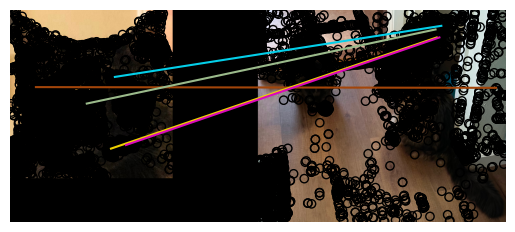

In [13]:
# Match descriptors between img1 and img3
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True, max_ratio=0.6)

# Display matches
fig, ax = plt.subplots()
plot_matched_features(img1, img3, keypoints0=keypoints1, keypoints1=keypoints3, matches=matches13, ax=ax)
ax.axis('off')
plt.show()

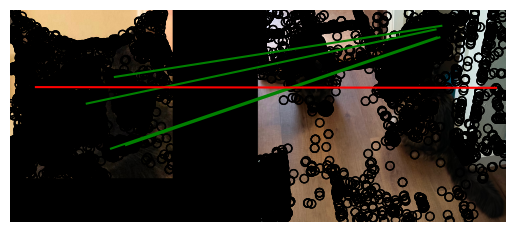

In [14]:
model13, inliers13 = ransac((keypoints1[matches13[:, 0]][:, ::-1], keypoints3[matches13[:, 1]][:, ::-1]),  # source and destination coordinates
                            AffineTransform,  # the model class
                            min_samples=3,  # minimum number of coordinates to fit the model
                            residual_threshold=2,  # maximum distance for a data point to be considered an inlier
                            max_trials=100)  # maximum number of iterations
outliers13 = inliers13 == False

# Display inlier and outlier matches
fig, ax = plt.subplots()
plot_matched_features(img1, img3, keypoints0=keypoints1, keypoints1=keypoints3, matches=matches13[inliers13], matches_color='g', ax=ax)
plot_matched_features(img1, img3, keypoints0=keypoints1, keypoints1=keypoints3, matches=matches13[outliers13], matches_color='r', ax=ax)
ax.axis('off')
plt.show()

In [15]:
# Get indices of matching keypoints for each of the images
kp1_idxs = matches13[inliers13, 0]
kp3_idxs = matches13[inliers13, 1]

# Get coordinates of matching keypoints for each of the images
matching_keypoints1 = keypoints1[kp1_idxs][:, ::-1] # keypoints are row, col but we want x, y
matching_keypoints3 = keypoints3[kp3_idxs][:, ::-1]
transformed_kp1 = model13(matching_keypoints1)

# Compute sum of squared distances between matched keypoints
distances = np.sum((transformed_kp1 - matching_keypoints3)**2, axis=1)
# Compute mean squared distance
mean_distance = np.mean(distances)
print('Mean squared distance: {}'.format(mean_distance))

# Compute the ratio of inliers/outliers
inlier_ratio = np.sum(inliers13) / len(inliers13)
print('Inlier ratio: {}'.format(inlier_ratio))

# Compute the ratio of inliers to features in the template
feature_ratio = np.sum(inliers13) / len(keypoints1)
print('Feature ratio: {} ({}/{} features)'.format(feature_ratio, np.sum(inliers13), len(keypoints1)))

Mean squared distance: 0.09925919761262358
Inlier ratio: 0.8
Feature ratio: 0.0009859502095144195 (4/4057 features)


Let's re-evaluate our first match using these new confidence metrics.

In [16]:
# Compute the ratio of inliers/outliers
inlier_ratio = np.sum(inliers12) / len(inliers12)
print('Inlier ratio: {:.4}'.format(inlier_ratio))

# Compute the ratio of inliers to features in the template
feature_ratio = np.sum(inliers12) / len(keypoints1)
print('Feature ratio: {:.4} ({}/{} features)'.format(feature_ratio, np.sum(inliers12), len(keypoints1)))

Inlier ratio: 0.8564
Feature ratio: 0.08233 (334/4057 features)


# Detection via Bounding Boxes

We can use the homography to transform the bounding box of the template image to the test image. This will give us a bounding box that should contain the template image in the test image.

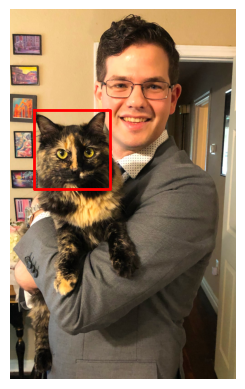

In [17]:
# Create a bounding box for the template image
bbox = np.array([[0, 0],
                 [0, img1.shape[0]],
                 [img1.shape[1], img1.shape[0]],
                 [img1.shape[1], 0]])

# Transform the bounding box to the coordinate system of the target image
transformed_bbox = model12(bbox)

minc = np.min(transformed_bbox[:, 0])
maxc = np.max(transformed_bbox[:, 0])
minr = np.min(transformed_bbox[:, 1])
maxr = np.max(transformed_bbox[:, 1])
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)

# bx, by = transform_template_bbox(template_corners, model12)

# Draw the bounding box on the target image
fig, ax = plt.subplots()
ax.imshow(img2)
ax.plot(bx, by, '-r', lw=2)
ax.axis('off')
plt.show()

# Putting it All Together

We can now put all of the pieces together to create a function that will detect the template image in a test image.

In [18]:
def detect_bobbie(img, template_keypoints, template_descriptors, template_bbox, max_ratio=0.6):
    # Extract keypoints from image using SIFT
    img_gray = rgb2gray(img)
    sift.detect_and_extract(img_gray)
    keypoints = sift.keypoints
    descriptors = sift.descriptors

    # Match descriptors between template and image
    matches = match_descriptors(template_descriptors, descriptors, cross_check=True, max_ratio=max_ratio)

    # Estimate affine transformation model using all coordinates
    model, inliers = ransac((template_keypoints[matches[:, 0]][:, ::-1], keypoints[matches[:, 1]][:, ::-1]),  # source and destination coordinates
                            AffineTransform,  # the model class
                            min_samples=3,  # minimum number of coordinates to fit the model
                            residual_threshold=2,  # maximum distance for a data point to be considered an inlier
                            max_trials=100)  # maximum number of iterations

    # Compute the mean squared distance between all inlier coordinates
    distances = np.sum((model(template_keypoints[matches[inliers, 0]][:, ::-1]) - keypoints[matches[inliers, 1]][:, ::-1])**2, axis=1)
    mean_distance = np.mean(distances)

    # Compute the ratio of inliers to features in the template
    feature_ratio = np.sum(inliers) / len(template_keypoints)

    # Compute the ratio of inliers/outliers
    inlier_ratio = np.sum(inliers) / len(inliers)

    # Transform the bounding box to the coordinate system of the target image
    transformed_bbox = model(template_bbox)

    minc = np.min(transformed_bbox[:, 0])
    maxc = np.max(transformed_bbox[:, 0])
    minr = np.min(transformed_bbox[:, 1])
    maxr = np.max(transformed_bbox[:, 1])
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)

    return mean_distance, feature_ratio, inlier_ratio, bx, by

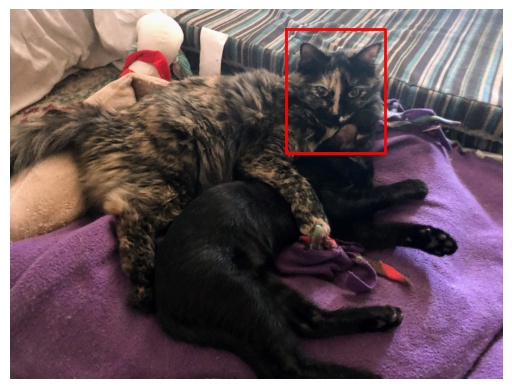

In [19]:
test_img = io.imread('img/bobbie4.jpeg')

mean_distance, feature_ratio, inlier_ratio, bx, by = detect_bobbie(test_img, keypoints1, descriptors1, bbox, max_ratio=0.7)

# Draw the bounding box on the target image
fig, ax = plt.subplots()
ax.imshow(test_img)
ax.plot(bx, by, '-r', lw=2)
ax.axis('off')
plt.show()